In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, LineString, Point
import xarray as xr
import os
import cmocean as cm
import numpy as np

# Add the path to the Tatsu's swot library
import sys
sys.path.append('../src/')
import tatsu_swot_utils as tatsu_swot
import tatsu_plotting_scripts as tatsu_swot_plot
import tatsu_data_loaders as tatsu_loader
import tatsu_download_swaths as tatsu_download

#turn off warnings
import warnings
warnings.filterwarnings("ignore")




# A notebook to try some plotting

# Load the swath/pass combos you want

Assuming you already have everything downloaded..

In [4]:
# Specify the path to the subsetted data
L3_kuroshio_path = f"../SWOT_L3/Unsmoothed_kuroshio"

# Define domain
# Rough East of Japan domain (Kuroshio-ish)
kuroshio_sw_corner = [140,15]
kuroshio_ne_corner = [170,40]
lat_lims = [kuroshio_sw_corner[1],kuroshio_ne_corner[1]]

# Define mission phase (1-day repeat vs science) and 
# cycles we are interested in
# Use sph_calval_swath for the 1-day repeats
path_to_sph_file="../orbit_data/sph_calval_swath.zip"
# Cycles 474 - 578 are from the 1-day repeat 
cycles = [str(c_num).zfill(3) for c_num in range(474,484)]



pass_IDs_list = tatsu_download.find_swaths(kuroshio_sw_corner, kuroshio_ne_corner,
                                           path_to_sph_file=path_to_sph_file)

cycle_data = {}
for cycle in cycles:
    cycle_data[cycle] = tatsu_loader.load_cycle(L3_kuroshio_path,fields=["time","ssha","ssha_unedited","ssha_noiseless","sigma0"],
                                                cycle=cycle,pass_ids=pass_IDs_list,subset=False,lats=lat_lims
                                               )


Loading SWOT_L3_LR_SSH_Unsmoothed_474_019_20230329T132147_20230329T141138_v1.0.2_kuroshio.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_475_004_20230330T002601_20230330T011706_v1.0.2_kuroshio.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_476_019_20230331T130302_20230331T135253_v1.0.2_kuroshio.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_478_004_20230401T235753_20230402T004859_v1.0.2_kuroshio.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_478_019_20230402T124418_20230402T133408_v1.0.2_kuroshio.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_479_004_20230402T234831_20230403T001052_v1.0.2_kuroshio.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_479_019_20230403T123455_20230403T132446_v1.0.2_kuroshio.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_480_004_20230403T233909_20230404T003014_v1.0.2_kuroshio.nc
Can't find path ../SWOT_L3/Unsmoothed_kuroshio/cycle_481
Can't find path ../SWOT_L3/Unsmoothed_kuroshio/cycle_482
Can't find path ../SWOT_L3/Unsmoothed_kuroshio/cycle_483


## Print the start and end times of the swaths to plot
Note this is the mean time over the section you are plotting

In [8]:
swaths_to_plot_subset = cycle_data["478"]

In [9]:
print(swaths_to_plot_subset[0].time.mean().values)
print(swaths_to_plot_subset[-1].time.mean().values)


2023-04-02T00:14:40.311773677
2023-04-02T13:18:37.197296193


# Plot the rough extent of the passes you downloaded


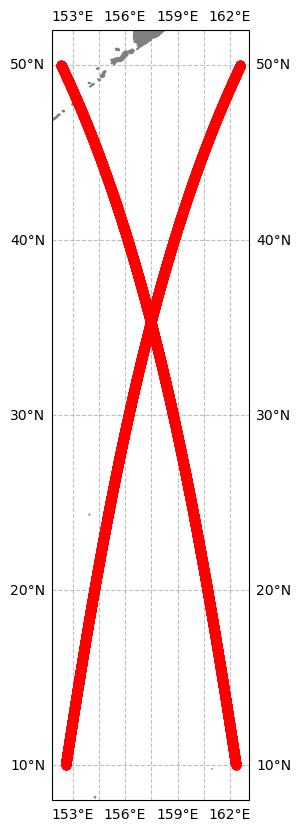

In [10]:
line_min = None
line_max = None

# Create a map using cartopy

fig, ax = plt.subplots(figsize=(5, 10), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

# add land, rivers, lakes, and coastlines
land = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='gray')
ax.add_feature(land)
ax.add_feature(cfeature.RIVERS, linewidth=0.5)
ax.add_feature(cfeature.LAKES, linewidth=0.5)


# add states and provinces
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

for i, swath in enumerate(swaths_to_plot_subset):
    ax.scatter(swath.longitude[:,300],swath.latitude[:,300],c="red",alpha=0.5,zorder=10+i, transform=ccrs.PlateCarree())

#ax.set_extent([-130, -120, 20, 45], crs=ccrs.PlateCarree())

# add colorbar and gridlines
gl = ax.gridlines(draw_labels=True, color='gray', 
                  alpha=0.5, linestyle='--')

plt.show()
plt.close()

# Plot the swaths side by side for comparison

In [ ]:
kwargs_signal = {"vmin":-0.4,"vmax":0.4,"cmap":cm.cm.balance}
cbar_kwargs = {"shrink":0.8,"orientation":"horizontal","pad":0.05}
field ="ssha_unedited"

fig, axs = plt.subplots(1,2,figsize=(20,20))

pass_ids = ["017","019"]

# make your plots
for i, ax in enumerate(axs):
    swath = swaths_to_plot_subset[i]
    plt.sca(ax)
    cax = ax.pcolor(swath[field], **kwargs_signal)
    plt.colorbar(cax, ax=ax, **cbar_kwargs)
    
    ax.set_yticks(swath.num_lines[:5000:100],np.around(swath.latitude[:5000:100,0].values,0))
    ax.set_xticks(swath.num_pixels[:5000:100],np.around(swath.longitude[0,:5000:100].values,0))
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    ax.set_ylabel("Latitude (deg)",fontsize=15)
    ax.set_xlabel("Longitude (deg)",fontsize=15)

    ax.set_title(f"{cycle}, pass ID: {pass_ids[i]}",fontsize=30)

    # flip if your swath is descending
    if swath.latitude[0,0].values > swath.latitude[-1,0].values:
        ax.invert_yaxis()
    if swath.longitude[0,0].values > swath.longitude[0,-1].values:
        ax.invert_xaxis()

axs[0].vlines([40,220],0,len(swath[field]))
axs[1].vlines([40,220],0,len(swath[field]))
    
fig.tight_layout()

plt.show()
plt.close()



In [ ]:
lim0 = 40
lim1 = 200


plt.plot(swath[field][0,:].num_pixels,np.std(swath[field],axis=0))
plt.xlabel("Cross-track distance")
plt.ylabel("Along-track SSHA $\sigma$")
plt.xticks(np.arange(5,131,10)*4,np.arange(5,131,10)-65)

plt.vlines([lim0,lim1,520-lim0,520-lim1],.04,.07,linestyle="--",color="k")
#plt.vlines([],.04,.07)
plt.ylim(0.04,0.065)
plt.grid()

In [ ]:
kwargs_signal = {"vmin":-0.2,"vmax":0.2,"cmap":cm.cm.balance}
cbar_kwargs = {"shrink":0.8,"orientation":"horizontal","pad":0.05}
field ="ssha_unedited"

fig, axs = plt.subplots(1,2,figsize=(20,5),dpi=300)

# make your plots
for i, ax in enumerate(axs):
    swath = swaths_to_plot_subset[i].isel(num_lines=slice(200,400),num_pixels=slice(0,519))
    plt.sca(ax)
    cax = ax.pcolor(swath[field], **kwargs_signal)
    plt.colorbar(cax, ax=ax, **cbar_kwargs)
    
    #ax.set_yticks(swath.num_lines[::100],np.around(swath.latitude[::100,0].values,0))
    #ax.set_xticks(swath.num_pixels[::100],np.around(swath.longitude[0,::100].values,0))
    #plt.xticks(fontsize=10)
    #plt.yticks(fontsize=10)
    #ax.set_ylabel("Latitude (deg)",fontsize=15)
    #ax.set_xlabel("Longitude (deg)",fontsize=15)

    ax.set_title(f"{cycle}, pass ID: {pass_ids[i]}",fontsize=30)

    # flip if your swath is descending
    if swath.latitude[0,0].values < swath.latitude[-1,0].values:
        ax.invert_yaxis()
    if swath.longitude[0,0].values > swath.longitude[0,-1].values:
        ax.invert_xaxis()

fig.tight_layout()

plt.show()
plt.close()


In [ ]:
kwargs_signal = {"vmin":-0.2,"vmax":0.2,"cmap":cm.cm.balance}
cbar_kwargs = {"shrink":0.8,"orientation":"horizontal","pad":0.05}
field ="ssha"

fig, axs = plt.subplots(1,2,figsize=(20,5),dpi=300)

# make your plots
for i, ax in enumerate(axs):
    swath = swaths_to_plot_subset[i].isel(num_lines=slice(200,400),num_pixels=slice(0,519))
    plt.sca(ax)
    cax = ax.pcolor(swath[field], **kwargs_signal)
    plt.colorbar(cax, ax=ax, **cbar_kwargs)
    
    #ax.set_yticks(swath.num_lines[::100],np.around(swath.latitude[::100,0].values,0))
    #ax.set_xticks(swath.num_pixels[::100],np.around(swath.longitude[0,::100].values,0))
    #plt.xticks(fontsize=10)
    #plt.yticks(fontsize=10)
    #ax.set_ylabel("Latitude (deg)",fontsize=15)
    #ax.set_xlabel("Longitude (deg)",fontsize=15)

    ax.set_title(f"{cycle}, pass ID: {pass_ids[i]}",fontsize=30)

    # flip if your swath is descending
    if swath.latitude[0,0].values < swath.latitude[-1,0].values:
        ax.invert_yaxis()
    if swath.longitude[0,0].values > swath.longitude[0,-1].values:
        ax.invert_xaxis()

fig.tight_layout()

plt.show()
plt.close()
